<a href="https://colab.research.google.com/github/kbrezinski/CS224W-GraphML/blob/main/notebooks/practice-pygod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pygod -q
!pip install torch-scatter torch-sparse \
 torch-cluster torch-spline-conv torch-geometric \
-f https://data.pyg.org/whl/torch-1.11.0+cu113.html -q

     |████████████████████████████████| 7.9 MB 2.6 MB/s 
     |████████████████████████████████| 3.5 MB 38.6 MB/s 
     |████████████████████████████████| 2.5 MB 46.8 MB/s 
     |████████████████████████████████| 750 kB 52.2 MB/s 
     |████████████████████████████████| 407 kB 5.0 MB/s 


In [8]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

data = Planetoid('./data/Cora', 'Cora', transform=T.NormalizeFeatures())[0]

In [9]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [10]:
import torch
from pygod.utils import gen_attribute_outliers, gen_structure_outliers

In [11]:
# based on "Deep Anomaly Detection on Attributed Networks"
data, ya = gen_attribute_outliers(data, n=100, k=50)  # randomly select n nodes, maximize euclidean distance from k nodes from node i in n. Change x_i to x_j
data, ys = gen_structure_outliers(data, m=10, n=10)   # randomly select m nodes, make connected and all outliers, do this until n cliques are generatd (total m x n outliers)
data.y = torch.logical_or(ys, ya).int()

In [12]:
data

Data(x=[2708, 1433], edge_index=[2, 11456], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
from pygod.models import DOMINANT
model = DOMINANT()

/usr/local/lib/python3.7/dist-packages/pygod/utils/utility.py:49: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


In [14]:
# contamination: 0.1 means n*contamination number of anomalies (10%)
model.fit(data)

DOMINANT(act=<function relu at 0x7f8c5395f560>, alpha=0.8, batch_size=2708,
     contamination=0.1, dropout=0.3, epoch=5, gpu=None, hid_dim=64,
     lr=0.005, num_layers=4, num_neigh=-1, verbose=False, weight_decay=0.0)

In [32]:
# higher more anomalies, output of model
model.decision_scores_

array([0.62749887, 0.5339008 , 0.64228678, ..., 0.41113883, 0.62834954,
       0.63697726])

In [27]:
print(f'Labels: {model.predict(data)}')
model.predict(data).sum() # 266 positive labels close to 10%

Labels: [0 0 0 ... 0 0 0]


266

In [33]:
# outlier scores? similar to decision scores?
print(f'Raw scores: {model.decision_function(data)}')

Raw scores: [0.62164152 0.52626574 0.63418972 ... 0.40173781 0.62247866 0.63074893]


In [25]:
# min-max conversion to convert to range [0, 1]
print(f'Probability: {model.predict_proba(data)}')

Probability: [[0.89580422 0.10419578]
 [0.93603999 0.06396001]
 [0.89051057 0.10948943]
 ...
 [0.98857404 0.01142596]
 [0.89545106 0.10454894]
 [0.89196212 0.10803788]]


In [38]:
labels, confidence = model.predict(data, return_confidence=True)
print('Labels:')
print(labels)
print('Confidence:')
print(sorted(confidence, reverse=False))  # 0.44 - 1 range?

Labels:
[0 0 0 ... 0 0 0]
Confidence:
[0.44484933495463586, 0.49571944686630554, 0.5213167206331206, 0.5213167206331206, 0.5213167206331206, 0.5213167206331206, 0.5802192653168872, 0.5974989058411551, 0.5974989058411551, 0.6223429532898619, 0.6223429532898619, 0.6291410693077916, 0.6528170195917942, 0.675862393418682, 0.693853416877199, 0.693853416877199, 0.6982060237361682, 0.6982060237361682, 0.6982060237361682, 0.7163909435243203, 0.7163909435243203, 0.7163909435243203, 0.7163909435243203, 0.7163909435243203, 0.7163909435243203, 0.7163909435243203, 0.7197848687167261, 0.7794315539595209, 0.7794315539595209, 0.7794315539595209, 0.7974942856349085, 0.7974942856349085, 0.7981592470158123, 0.8146077818803944, 0.8162522775786752, 0.8162522775786752, 0.8162522775786752, 0.8162522775786752, 0.8162522775786752, 0.8333380224194749, 0.9078385259098942, 0.9143999542352319, 0.9346168712735221, 0.9620639945261334, 0.965204620543871, 0.9673754012770972, 0.9695972963902612, 0.9735131026741769, 0.9

In [34]:
# perturb the model slighty, "Quantifying the confidence of anomaly detectors in their example-wise predictions"
model.predict_confidence(data)

array([1., 1., 1., ..., 1., 1., 1.])

In [47]:
model.threshold_

0.83399555683136

In [50]:
from pygod.utils.metric import \
    eval_roc_auc, \
    eval_recall_at_k, \
    eval_precision_at_k, \
    eval_average_precision

k = 250

auc_score = eval_roc_auc(data.y.numpy(), outlier_scores)  # average ROC-AUC acrpss different labels
recall_at_k = eval_recall_at_k(data.y.numpy(), outlier_scores,  # recall scores for top k nodes with highest outlier score
                               k=k, threshold=model.threshold_)
precision_at_k = eval_precision_at_k(data.y.numpy(), outlier_scores,  # precision scores for top k nodes with highest outlier score
                                     k=k, threshold=model.threshold_)

print('AUC Score:', auc_score)
print(f'Recall@{k}:', recall_at_k)  # actual positives were correct
print(f'Precision@{k}:', precision_at_k)  # positives were actuall positives (low FP)
print(f'Avg Precision:', eval_average_precision(data.y.numpy(), outlier_scores))

AUC Score: 0.9368524567837192
Recall@250: 0.6030150753768844
Precision@250: 0.48
Avg Precision: 0.4174918693724443


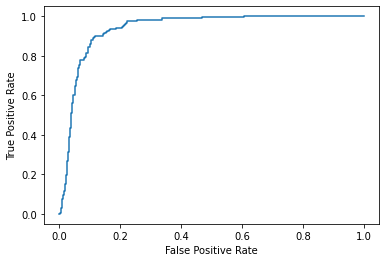

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# use pos_label=None pos_label is set to 1 if {0, 1}
fpr, tpr, _ = roc_curve(data.y.numpy(), outlier_scores, pos_label=None)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

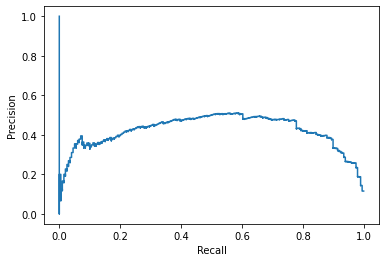

In [53]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# disregards TN rate which has a high impact on imbalance problem (more weight to minority graph)
prec, recall, _ = precision_recall_curve(data.y.numpy(), outlier_scores, pos_label=None)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()